## Cats and Dogs (3/3)
### Building powerful image classification models using very little data
By Francois Chollet: 
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

Esta é a última parte de três do experimento de *transfer learning*.

Neste experimento, a rede VGG é montada completa, com a parte convolucional e a parte da rede densa treinada no notebook anterior. As camadas finais da parte convolucional é liberada para o treinamento (*fine tuning*).

In [8]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import os
import sys
import numpy as np
import numpy.random as nr

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import load_model
from keras.models import Model
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD, RMSprop

print('Keras ', keras.__version__)

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

import os
os.makedirs('../../models', exist_ok=True)

Keras  2.0.4


In [9]:
import keras.backend as K

# K.set_image_data_format('channels_first')
K.set_floatx('float32')
image_format = K.image_data_format()

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(image_format))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: ['/gpu:0']


## Dataset

https://www.kaggle.com/c/dogs-vs-cats/data


In [10]:
train_data_dir = '../../datasets/CatsDogs/train'
valid_data_dir = '../../datasets/CatsDogs/validation'
nb_train_samples = 2000
nb_valid_samples = 800

batch_size = 40
img_width, img_height = 150, 150

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

valid_generator = test_datagen.flow_from_directory(
        valid_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## VGG Features

[![VGG Network Layers](https://blog.keras.io/img/imgclf/vgg16_modified.png)]()

In [11]:
# Esta função contorna um problema:
#     - model.load_weights somente carrega pesos de camadas "treináveis";
#     - como nosso modelo possui camadas com trainable=False mas que tem pesos
#       aprendidos em outras ocasiões, é preciso iludir o get_weights de forma
#       que os pesos sejam carregados.
def fix_load_model_and_history(model_name, loss='binary_crossentropy', opt='adam', metrics=[]):
    import h5py, json
    import pickle
    from keras.models import model_from_config
    
    f = h5py.File(model_name + '.model', mode='r')
    model_config = f.attrs.get('model_config')
    model_config = json.loads(model_config.decode('utf-8'))

    untrainable = []
    for ii, lay in enumerate(model_config['config']['layers']):
        if 'trainable' in lay['config'].keys():
            if not lay['config']['trainable']:
                lay['config']['trainable'] = True
                untrainable.append(ii)
            
    model = model_from_config(model_config)
    model.load_weights(model_name + '.model')

    for ii in untrainable:
        model.layers[ii].trainable = False

    model.compile(loss=loss, optimizer=opt, metrics=metrics)
    return model, pickle.load(open(model_name + '.history', 'rb'))


In [12]:
from keras.applications.vgg16 import VGG16

model_name = '../../models/cats_dogs_vgg_finetune'   # modelo da rede atual
top_model_name = '../../models/cats_dogs_vgg.model'  # modelo da rede mynet densa treinada no notebook anterior

if not os.path.isfile(model_name + '.model'):
    # History, checkpoint, earlystop, loss plotter:
    histo = TrainingPlotter(n=1, filepath=model_name, patience=15)
    
    print("[INFO] creating model...")
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
    
    # build a classifier model and put on top of the convolutional model
    x = Flatten()(vgg.output)
    x = Dense(256, activation='relu', name='d1')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid', name='d2')(x)
    
    model = Model(inputs=vgg.input, outputs=x)

    print('Model layers:')
    for i, layer in enumerate(model.layers):
        print('    {:2d} {:15s} {}'.format(i, layer.name, layer))
    
    # Carrego os pesos treinados anteriormente
    w1, b1, w2, b2 = load_model(top_model_name).get_weights()
    
    # Coloco nas camadas densas finais da rede atual
    model.layers[20].set_weights([w1, b1])
    model.layers[22].set_weights([w2, b2])
    
    # set the first 15 layers (up to the last conv block)
    # to non-trainable (weights will not be updated)
    for layer in model.layers[:15]:
        layer.trainable = False

    print("[INFO] compiling model...")
    # compile the model with a SGD/momentum optimizer
    # and a very slow learning rate.
    model.compile(loss='binary_crossentropy',
                  optimizer=SGD(lr=1e-4, momentum=0.9),
                  metrics=['accuracy'])
else:
    print("[INFO] loading model...")
    model, histo = fix_load_model_and_history(model_name, 
                                              loss='binary_crossentropy', 
                                              opt=SGD(lr=1e-4, momentum=0.9), 
                                              metrics=['accuracy'])

model.summary()


[INFO] loading model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)    

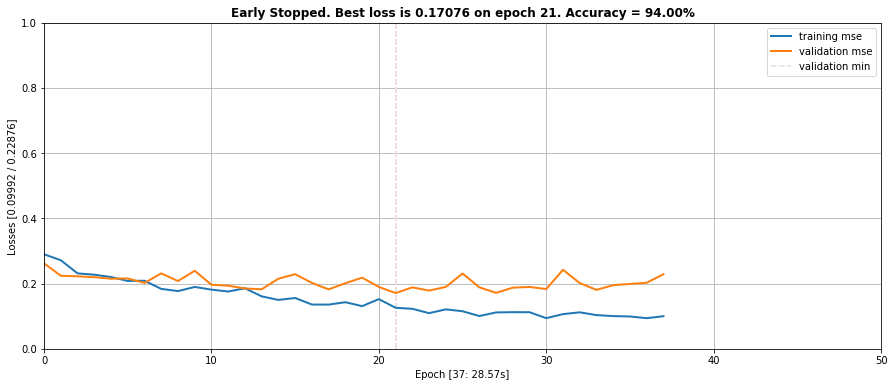

In [13]:
nb_epoch = 50
ploss = 1.0

train_steps = nb_train_samples / batch_size
valid_steps = nb_valid_samples / batch_size

nepochs = nb_epoch - histo.get_nepochs()

fig = plot.figure(figsize=(15,6))
plot.ylim(0.0, ploss)
plot.xlim(0, nb_epoch)
plot.grid(True)

if nepochs > 0:
    print("[INFO] training...")
    try:
        # fine-tune the model
        model.fit_generator(
            train_generator,
            steps_per_epoch=train_steps,
            epochs=nb_epoch,
            validation_data=valid_generator,
            validation_steps=valid_steps,
            verbose=0,
            callbacks=[histo],
        )
        
    except KeyboardInterrupt:
        pass

else:
    print("[INFO] plotting...")
    # plot history


In [15]:
print("[INFO] loading model...")
model, histo = fix_load_model_and_history(model_name, loss='binary_crossentropy', 
                                          opt=SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])
print('       from epoch {}'.format(histo.best_epoch))
print("[INFO] evaluating...")
loss, accuracy = model.evaluate_generator(valid_generator, valid_steps)
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))


[INFO] loading model...
       from epoch 21
[INFO] evaluating...
[INFO] accuracy: 93.87%


## Aprendizados com este notebook

